# Description:

This notebook contains several experiments with bokeh and hexagonal matrices in order to produce a suitable U-matrix and test the interactive components we want to include in the visualization.

In [1]:
from bokeh.colors import RGB
from bokeh.core.properties import AngleSpec
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper, AdaptiveTicker
from bokeh.plotting import figure, output_file
from bokeh.util.hex import cartesian_to_axial
from matplotlib.pyplot import get_cmap
from matplotlib.colors import rgb2hex

import os
from collections import Counter
import glob
from collections import defaultdict
import sompy
import numpy as np
import pandas as pd
from src import PROJECT_ROOT
from src.features.embedding_extractor import (embeddings_generator,
                                              format_embedding_files,
                                              read_data)

# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

In [2]:
data_file = os.path.join(PROJECT_ROOT, "data","processed", "newsapi_docs.csv")
fig_dir = os.path.join(PROJECT_ROOT, "outputs", "figures", "som")
embeddings_file = glob.glob(os.path.join(PROJECT_ROOT, "outputs/saved_embeddings/train_doc2vecdbowd100n5mc2t*.npy"))
if len(embeddings_file) > 1:
    raise ValueError("There is more than one file with the same pattern as the model path.")
else:
    embeddings_file = embeddings_file[0]

In [3]:
_, model_tag = os.path.splitext(os.path.basename(embeddings_file))[0].split("_")

# Reading data into memory
_, train_docs, _ = read_data(data_file)
train_labels = train_docs['category']

# Obtain the vectorized corpus
embedding_dict = format_embedding_files([embeddings_file])
gen = embeddings_generator(embedding_dict)
_, vect_train_corpus = list(gen)[0]

# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

som = sompy.SOMFactory().build(
    vect_train_corpus,
    mapsize=(50, 50),
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa'
)
som.train(n_job=-1, verbose='info', train_rough_len=5, train_finetune_len=5)

Read data has a size of 3720Kb
Formatting data...
61998 documents from train set out of 77498 documents
Loading embeddings of doc2vecdbowd100n5mc2t12...
 Training...
 pca_linear_initialization took: 0.727000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 5

 epoch: 1 ---> elapsed time:  7.067000, quantization error: 9.286615

 epoch: 2 ---> elapsed time:  7.365000, quantization error: 9.817200

 epoch: 3 ---> elapsed time:  7.146000, quantization error: 9.636822

 epoch: 4 ---> elapsed time:  6.995000, quantization error: 9.455126

 epoch: 5 ---> elapsed time:  7.023000, quantization error: 9.205475

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  7.103000, quantization error: 8.893102

 epoch: 2 ---> elapsed time:  7.403000, quantization error: 8.763216

 epoch: 3 ---> elapsed time:  6.761000, quantization error: 8.640320

 epoch: 4 ---> elapsed time:  7.348000, quantization error: 8

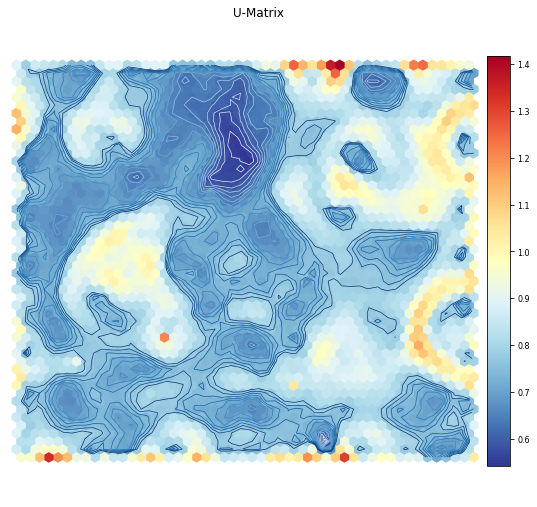

In [4]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(9, 9, 'U-Matrix', show_axis=True, text_size=8, show_text=True)

_, umat = u.show(
    som, 
    distance=2, 
    contour=True,
    blob=False
)

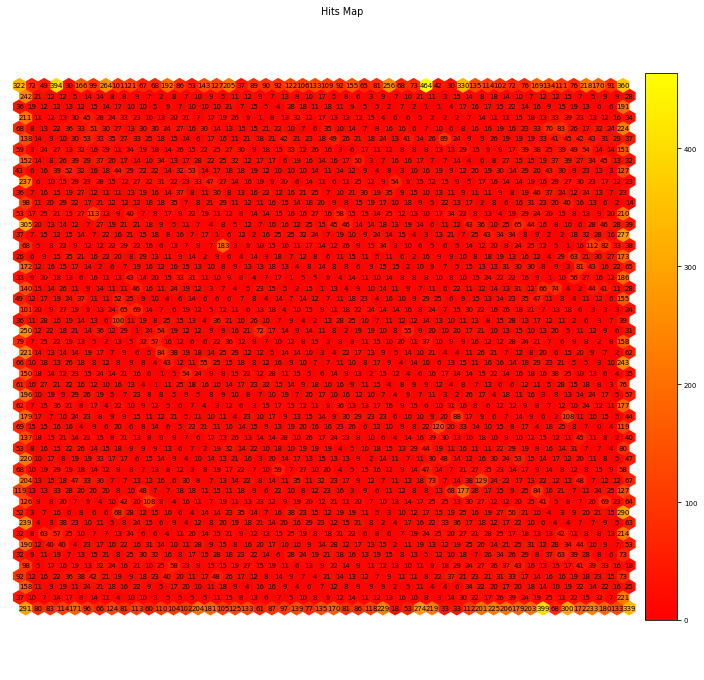

In [5]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)

## U-matrix using Bokeh
### Challenges:

- Given a grid of size (x, y), place x\*y hexagons to form a hexagonal grid with odd-row offset:
    - locate the centers of each hexagon
    - figure out the right hexagon size
    - figure out the right offset value
    - ensure the grid is preserved when the image is changed (zoom, image size, screen size, etc)

Reference https://www.redblobgames.com/grids/hexagons/:
-  In the pointy orientation, a hexagon has width w = sqrt(3) * size and height h = 2 * size. The sqrt(3) comes from sin(60°).


Change to Plotly over Bokeh:

- https://nbviewer.jupyter.org/gist/empet/8e466955c9e30f7471b4fb45c3a0fb21

- https://github.com/plotly/plotly.js/issues/1574

Dashboard with Bokeh:
- https://towardsdatascience.com/data-visualization-with-bokeh-in-python-part-iii-a-complete-dashboard-dc6a86aa6e23

In [6]:
# Build the interactive U-Matrix
msz = som.codebook.mapsize  # The mapsize of the codebook (tuple)
xx, yy = np.meshgrid(np.arange(msz[0]), np.arange(msz[1]))
xx, yy = xx.astype(float).T, yy.astype(float).T
# proj = som.find_bmu(som._data, njb=-1)
proj = som._bmu[0]

# hitmap
counts = Counter(proj)
counts = [counts.get(x, 0) for x in range(som.codebook.nnodes)]
hitmap = np.array(counts).reshape(msz[0], msz[1])[::-1]

# hitmap of each category
categories = train_labels.unique()
categ_freq = []
for i in range(som.codebook.nnodes):
    unit_labels = train_labels.values[proj==i]
    unit_freq = []
    for j in categories:
        unit_freq.append(np.sum(unit_labels==j))
    categ_freq.append(unit_freq)
categ_freq = np.array(categ_freq).reshape(50,50,7)[::-1]


# get each unit attributes
hex_values = defaultdict(list)

uid, w, h = 0, np.sqrt(3), 2
xx_offset = np.zeros_like(xx)
xx_offset[:, 1::2]  += 0.5 * w
hex_values['hex_centre_col'] = np.rot90(np.flip((xx * w - xx_offset), axis=0)).flatten()
hex_values['hex_centre_row'] = np.rot90(np.flip((yy * h * 3 /4), axis=0)).flatten()
hex_values['hex_dist'] = umat.flatten()
hex_values['hex_freq'] = hitmap.flatten()
for i, j in enumerate(categories):
    rfreq_categ = np.divide(categ_freq[:,:,i], hitmap,
                            out=np.zeros_like(categ_freq[:,:,i], dtype=float),
                            where=hitmap!=0) * 100
    hex_values[f'hex_{j}'] = rfreq_categ.astype(int).flatten()

In [7]:
# initialise figure/plot
fig = figure(title="SOM: Hexagonal Topology",
             plot_height=700, plot_width=700,
             match_aspect=True, toolbar_location='right')

# define color_mapper
colormap = get_cmap('RdYlBu_r')
pallete_colors = [rgb2hex(colormap(i)) for i in range(colormap.N)]
color_mapper = LinearColorMapper(palette=pallete_colors)

# create data stream for plotting
q, r = cartesian_to_axial(hex_values['hex_centre_col'], hex_values['hex_centre_row'], 
                          size=1, orientation='pointytop')
data = {k: v for k, v in hex_values.items() if k not in ['hex_centre_row', 'hex_centre_col']}
data['q'], data['r'] = q, r
source_hex = ColumnDataSource(data)

# add shapes to plot
fig.hex_tile(q='q', r='r', source=source_hex, line_color='gray',
             fill_color={'field': 'hex_dist', 'transform': color_mapper})

# add colorbar
color_bar = ColorBar(color_mapper=color_mapper, ticker=AdaptiveTicker(), 
                     label_standoff=10, border_line_color=None, 
                     height=500, location=(0, 75))
fig.add_layout(color_bar, 'right')

# add hover-over tooltip
fig.add_tools(HoverTool(
    tooltips=[
        ("distance", '@hex_dist'),
        ("frequency", '@hex_freq'),
        ("health", '@hex_health%'),
        ("general", '@hex_general%'),
        ("entretainment", '@hex_entertainment%'),
        ("sports", '@hex_sports%'),
        ("tech", '@hex_technology%'),
        ("business", '@hex_business%'),
        ("science", '@hex_science%')
    ],
    mode="mouse",
    point_policy="follow_mouse"
))

# figure options
fig.title.align = "center"
fig.title.text_font_size = "25px"
fig.grid.visible = False
fig.axis.visible = False

show(fig)

- The grid obtained has w=sqrt(3), h=2 and size=1. Total grid hight is 75.5 and total width is ~ 87.469 (each row has 50 * sqrt(3) width)